In [7]:
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torchaudio.transforms import Resample, MelSpectrogram
import torch
import torchaudio
from torchaudio.transforms import Resample, MelSpectrogram
from torch.utils.data import Dataset
import librosa
import numpy as np
import pandas as pd
import tqdm

In [77]:
Tess = "TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"

In [78]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

In [80]:

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        


,Emotions,Path
0,angry,TESS Toronto emotional speech set data/TESS To...
1,angry,TESS Toronto emotional speech set data/TESS To...
2,angry,TESS Toronto emotional speech set data/TESS To...
3,angry,TESS Toronto emotional speech set data/TESS To...
4,angry,TESS Toronto emotional speech set data/TESS To...


In [81]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df

,Emotions,Path
0,angry,TESS Toronto emotional speech set data/TESS To...
1,angry,TESS Toronto emotional speech set data/TESS To...
2,angry,TESS Toronto emotional speech set data/TESS To...
3,angry,TESS Toronto emotional speech set data/TESS To...
4,angry,TESS Toronto emotional speech set data/TESS To...
...,...,...
2795,sad,TESS Toronto emotional speech set data/TESS To...
2796,sad,TESS Toronto emotional speech set data/TESS To...
2797,sad,TESS Toronto emotional speech set data/TESS To...
2798,sad,TESS Toronto emotional speech set data/TESS To...


In [82]:
Tess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  2800 non-null   object
 1   Path      2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


In [84]:
data_path = pd.concat([Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(2800, 2)

In [85]:
data_path.head()


,Emotions,Path
0,angry,TESS Toronto emotional speech set data/TESS To...
1,angry,TESS Toronto emotional speech set data/TESS To...
2,angry,TESS Toronto emotional speech set data/TESS To...
3,angry,TESS Toronto emotional speech set data/TESS To...
4,angry,TESS Toronto emotional speech set data/TESS To...


In [90]:
print(data_path['Emotions'].value_counts())

angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: Emotions, dtype: int64


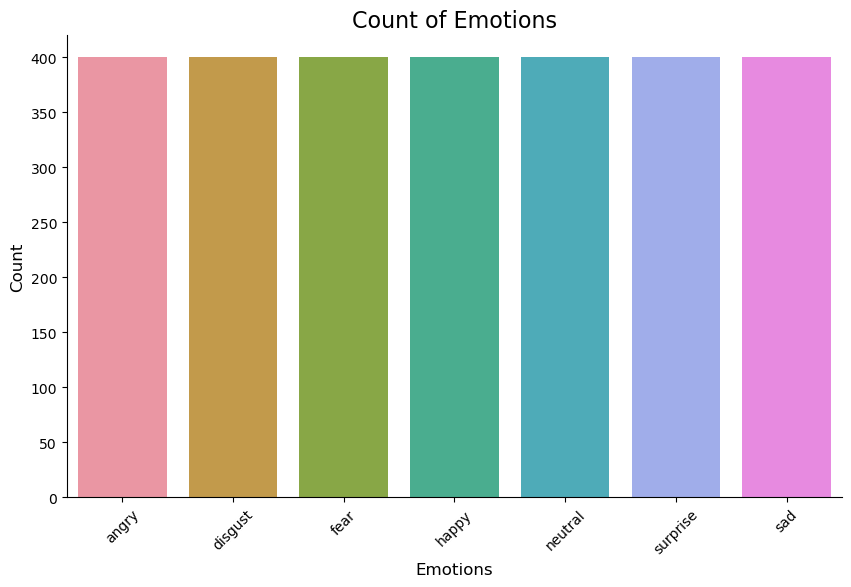

In [92]:
emotion_counts = data_path['Emotions'].value_counts()

sns.set_palette('spring')
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)  
sns.despine(top=True, right=True, left=False, bottom=False)

In [99]:
#Data Augmentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

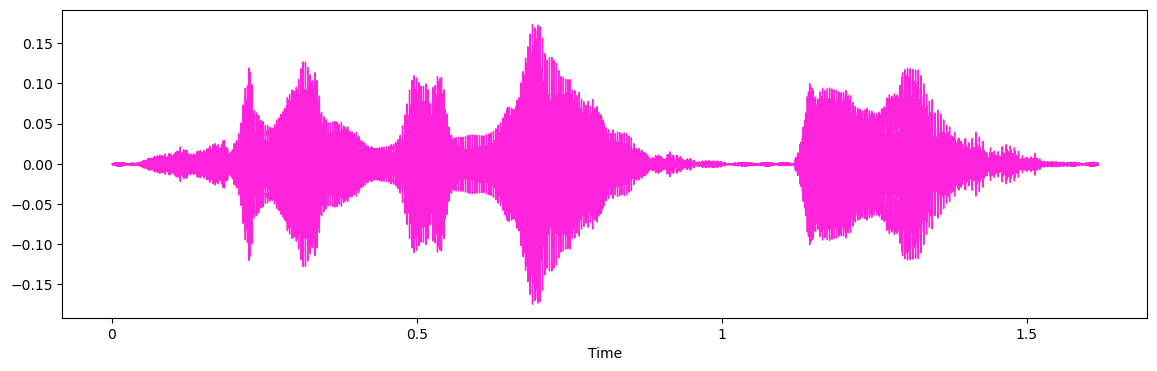

In [95]:
#1. Simple Audio
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

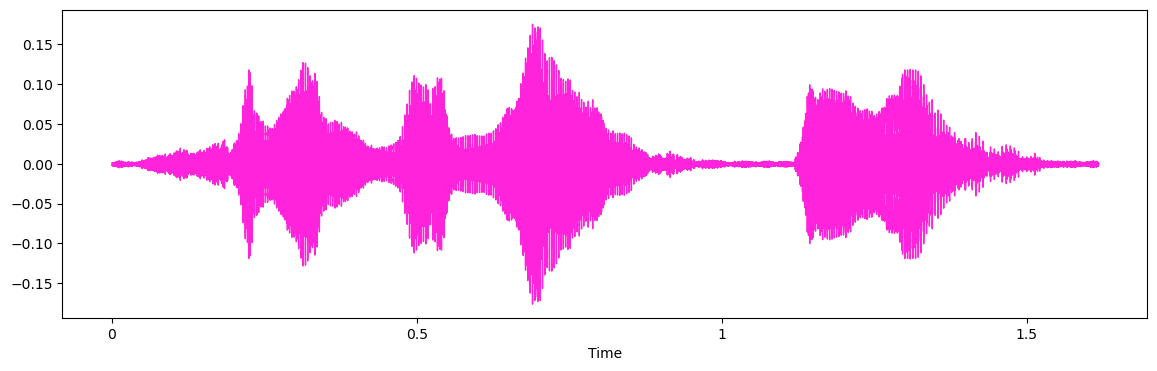

In [96]:
#2. Noise Injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

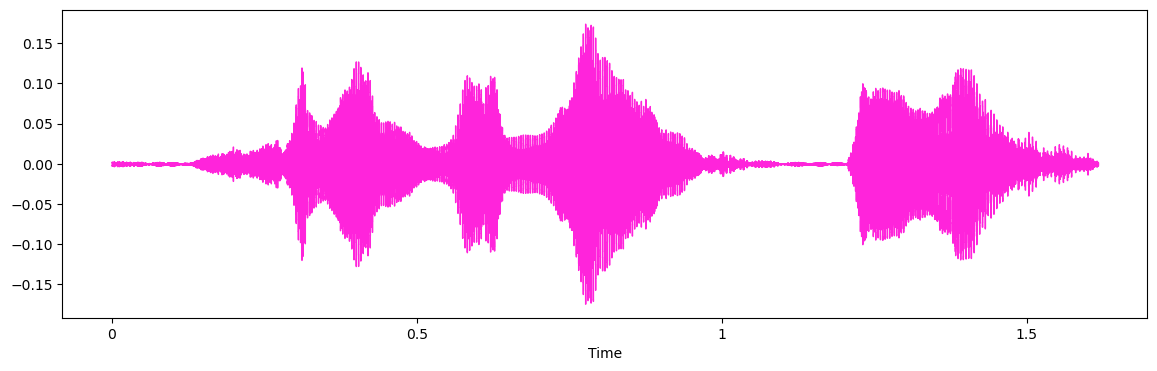

In [101]:
#3. Shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [104]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    
    return result

In [105]:
print(data_path.shape)
data_path.head()

(2800, 2)


,Emotions,Path
0,angry,TESS Toronto emotional speech set data/TESS To...
1,angry,TESS Toronto emotional speech set data/TESS To...
2,angry,TESS Toronto emotional speech set data/TESS To...
3,angry,TESS Toronto emotional speech set data/TESS To...
4,angry,TESS Toronto emotional speech set data/TESS To...


In [106]:
data_path['Emotions'].value_counts()

angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: Emotions, dtype: int64

In [107]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    print(path," : ",emotion)
    feature = get_features(path)
#print(feature)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  :  angry
TESS Toronto emotional speech set data/TESS Toronto emotional spee

In [108]:
len(X), len(Y), data_path.Path.shape

(5600, 5600, (2800,))

In [109]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.054342,0.538993,0.596808,0.396304,0.364695,0.441099,0.413557,0.373404,0.568096,0.573010,...,0.000105,0.000157,0.000185,0.000133,0.000134,0.000070,0.000038,0.000034,6.250596e-06,angry
1,0.177341,0.655850,0.728494,0.554264,0.506136,0.569259,0.574343,0.457071,0.616985,0.684088,...,0.000745,0.000743,0.000781,0.000682,0.000691,0.000567,0.000606,0.000584,5.295780e-04,angry
2,0.058006,0.635519,0.406851,0.370775,0.404711,0.507197,0.455434,0.395454,0.421722,0.353537,...,0.000115,0.000082,0.000030,0.000011,0.000015,0.000021,0.000019,0.000015,9.260864e-07,angry
3,0.226618,0.804306,0.598492,0.541379,0.564752,0.605381,0.485159,0.463379,0.514939,0.489317,...,0.001395,0.001250,0.001191,0.001127,0.001129,0.001279,0.001373,0.001342,1.226428e-03,angry
4,0.113484,0.524840,0.684483,0.540807,0.336128,0.356515,0.429876,0.339963,0.316307,0.422898,...,0.000358,0.000351,0.000266,0.000088,0.000100,0.000195,0.000147,0.000067,2.281613e-06,angry


In [110]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 7.0+ MB
